In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import network_fcn as vae
import SiameseNetwork3_2 as smsn
import argparse
import pickle
from keras.layers import concatenate, Flatten
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from scipy import spatial
import os
from os.path import dirname, abspath
from utils import *
from itertools import combinations
# from plotnine import ggplot, aes, geom_point,labs, scale_size, theme, element_text, stat_summary, scale_colour_gradient, scale_colour_gradient2, geom_boxplot
import warnings
import matplotlib.colors as mcolors

[0.66647059 0.62343137 0.71069161 0.70956916 0.61404762 0.70913832
 0.69944444 0.7083415  0.72797919]
[0.67       0.67316327 0.71       0.71       0.76959184 0.79969388
 0.79438776 0.82973088 0.8154902 ]
[0.75087858 0.82387755 0.77519608 0.77519608 0.895      0.91539216
 0.8753799  0.8727466  0.9       ]


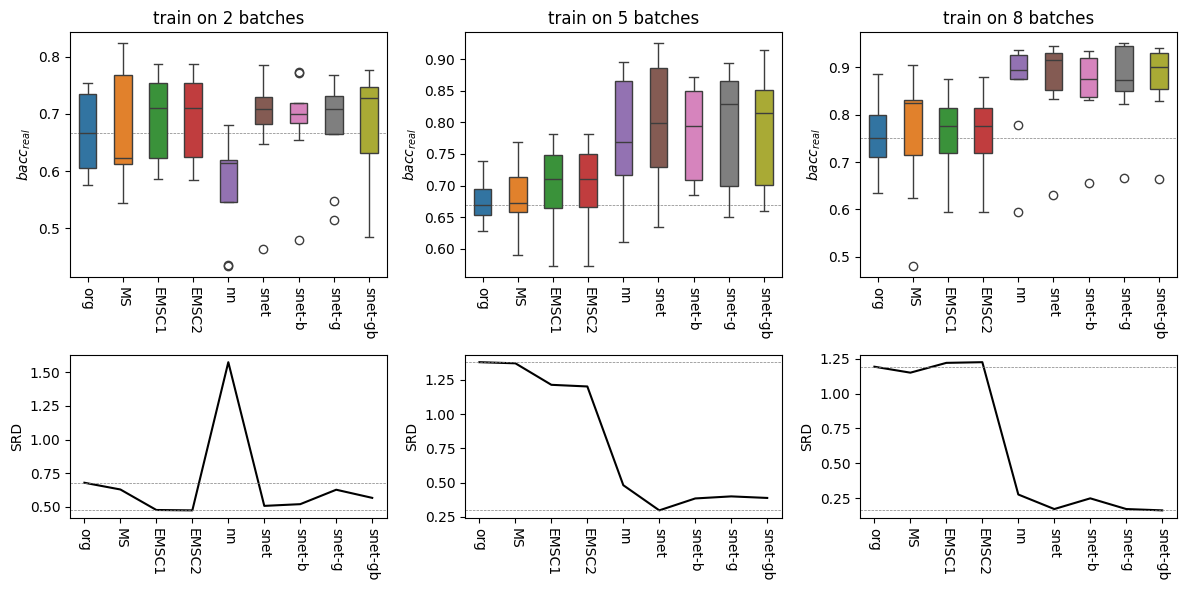

In [2]:
db_methods = ['org', 'MS', 'EMSC1', 'EMSC2', 'nn', 'snet', 'snet-b', 'snet-g', 'snet-gb', ] #, 'snet-EMSC1', 'snet-g-EMSC1', 'snet-b-EMSC1', 'snet-gb-EMSC1']
cols = list(mcolors.TABLEAU_COLORS)
fig, ax = plt.subplots(2, 3, figsize=(12, 6), height_ratios=[1.5, 1])
n_bats = [2, 5, 8]
for n_bat in range(len(n_bats)):
    with open(dirname(abspath(os.getcwd())) + '/results/accs_mt1_org_' + str(n_bats[n_bat]) + '_Batch.pkl', 'rb') as f:
        accs, methods, b_trains, b_tests = pickle.load(f)
    uni_batches = np.unique(b_tests)
    acc_all = []
    for i in range(len(db_methods)):
        for j in range(len(uni_batches)):
            acc_all = np.append(acc_all, np.mean(accs[(methods==db_methods[i]) & (b_tests==uni_batches[j])]))
    acc_all = np.reshape(acc_all, (len(db_methods), len(uni_batches)))
    ax[0, n_bat].axhline(y=np.median(acc_all[0,:]), color='gray', linestyle='dashed', linewidth=0.5)
    print(np.median(acc_all, axis=1))
    sns.boxplot(data=acc_all.T, width=0.5, ax=ax[0, n_bat])
    ax[0, n_bat].set_xticks(range(len(db_methods)), db_methods, rotation=-90)
    ax[0, n_bat].set_ylabel('$bacc_{real}$')
    ax[0, n_bat].set_title('train on ' + str(n_bats[n_bat]) + ' batches')

    val_srd = SRD(acc_all.T)
    ax[1, n_bat].plot(range(len(db_methods)), val_srd, color='black')
    ax[1, n_bat].set_xticks(range(len(db_methods)), db_methods, rotation=-90)
    ax[1, n_bat].set_ylabel('SRD')
    ax[1, n_bat].axhline(y=val_srd[0], color='gray', linestyle='dashed', linewidth=0.5)
    ax[1, n_bat].axhline(y=np.min(val_srd), color='gray', linestyle='dashed', linewidth=0.5)
plt.tight_layout()
plt.show()

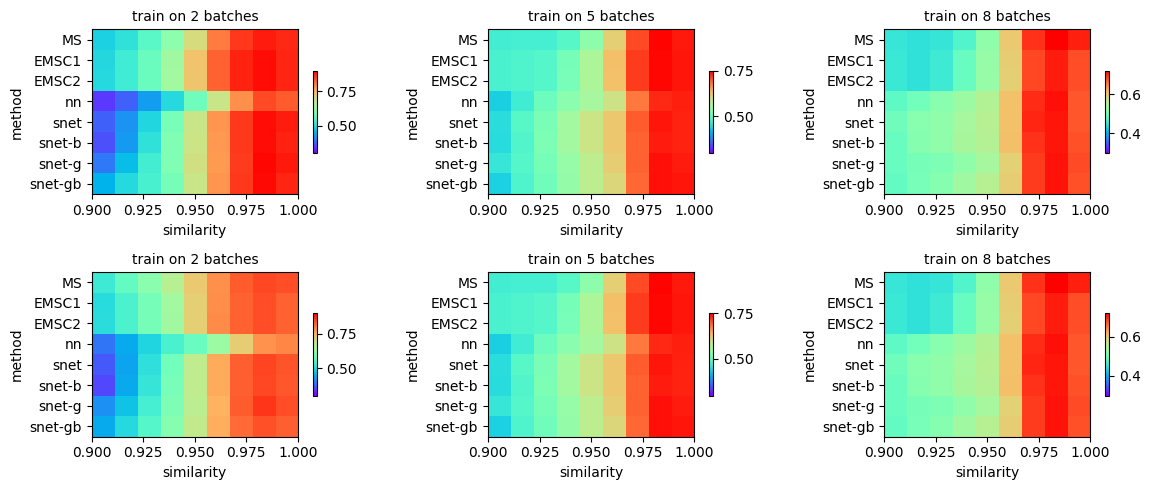

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(12, 5))
cols = list(mcolors.TABLEAU_COLORS)
v_maxs = [0.9, 0.75, 0.72]
db_methods = ['sb-MS', 'sb-EMSC1', 'sb-EMSC2', 'sb-nn', 'sb-snet', 'sb-snet-b', 'sb-snet-g', 'sb-snet-gb'] #, 'sb-snet-EMSC1', 'sb-snet-b-EMSC1', 'sb-snet-g-EMSC1', 'sb-snet-gb-EMSC1']
n_bats = [2,5,8]
for n_bat in range(len(n_bats)):
    with open(dirname(abspath(os.getcwd())) + '/results/accs_mt1_gen_' + str(n_bats[n_bat]) + '_batch.pkl', 'rb') as f:
        accs, methods, b_trains, val_cors = pickle.load(f)
    uni_cors = np.unique(val_cors)[1:]
    c_vals = np.array(range(90, 99))
    accs_all = []
    for m in db_methods:
        ix = np.argwhere(methods==m)[:,0]
        tc_tmp = val_cors[ix]
        for tc in uni_cors:
            ixx = np.argwhere(tc_tmp == tc)[:,0]
            vals = accs[ix][ixx]
            accs_all = np.append(accs_all, np.mean(vals))
    accs_all = np.reshape(accs_all, [len(db_methods), len(uni_cors)])
    
    pl = ax[0, n_bat].imshow(accs_all, 'rainbow', extent=(0.9, 1, len(db_methods), 0), aspect=0.01, vmin=0.3, vmax=v_maxs[n_bat])
    fig.colorbar(pl, ax=ax[0, n_bat], shrink=0.5)
    ax[0, n_bat].set_ylabel('method', fontsize=10)
    ax[0, n_bat].set_xlabel('similarity', fontsize=10)
    ax[0, n_bat].set_title('train on ' + str(n_bats[n_bat]) + ' batches', fontsize=10)  
    ax[0, n_bat].set_yticks(np.array(range(len(db_methods)))+0.5, ('MS', 'EMSC1', 'EMSC2', 'nn', 'snet', 'snet-b', 'snet-g', 'snet-gb'), fontsize=10) 
    
    db_methods = ['db-MS', 'db-EMSC1', 'db-EMSC2', 'db-nn', 'db-snet', 'db-snet-b', 'db-snet-g', 'db-snet-gb'] #, 'db-snet-EMSC1', 'db-snet-b-EMSC1', 'db-snet-g-EMSC1', 'db-snet-gb-EMSC1']
    acc_org = np.mean(accs[methods=='org'])
    accs_all = []
    for m in db_methods:
        ix = np.argwhere(methods==m)[:,0]
        tc_tmp = val_cors[ix]
        for tc in uni_cors:
            ixx = np.argwhere(tc_tmp == tc)[:,0]
            vals = accs[ix][ixx]
            accs_all = np.append(accs_all, np.mean(vals))
    accs_all = np.reshape(accs_all, [len(db_methods), len(uni_cors)])
    
    pl = ax[1, n_bat].imshow(accs_all, 'rainbow', extent=(0.9, 1, len(db_methods), 0), aspect=0.01, vmin=0.3, vmax=v_maxs[n_bat])
    fig.colorbar(pl, ax=ax[1, n_bat], shrink=0.5)
    ax[1, n_bat].set_xlabel('similarity', fontsize=10)
    ax[1, n_bat].set_ylabel('method', fontsize=10)
    ax[1, n_bat].set_title('train on ' + str(n_bats[n_bat]) + ' batches', fontsize=10)  
    ax[1, n_bat].set_yticks(np.array(range(len(db_methods)))+0.5, ('MS', 'EMSC1', 'EMSC2', 'nn', 'snet', 'snet-b', 'snet-g', 'snet-gb'), fontsize=10) 
plt.tight_layout()
plt.show()

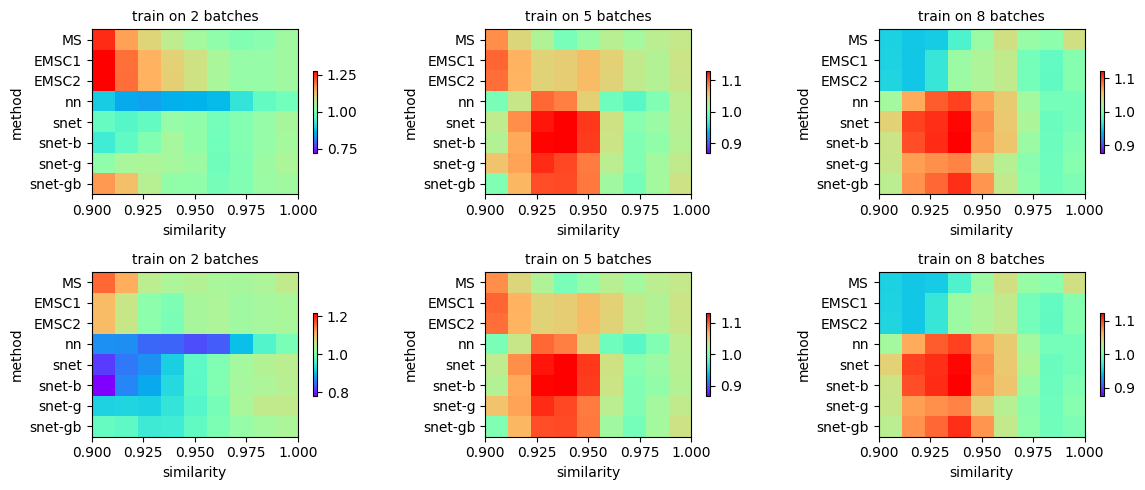

In [4]:
fig, ax = plt.subplots(2, 3, figsize=(12, 5))
cols = list(mcolors.TABLEAU_COLORS)

db_methods = ['sb', 'sb-MS', 'sb-EMSC1', 'sb-EMSC2', 'sb-nn', 'sb-snet', 'sb-snet-b', 'sb-snet-g', 'sb-snet-gb'] #, 'sb-snet-EMSC1', 'sb-snet-b-EMSC1', 'sb-snet-g-EMSC1', 'sb-snet-gb-EMSC1']
n_bats = [2, 5, 8]
for n_bat in range(len(n_bats)):
    with open(dirname(abspath(os.getcwd())) + '/results/accs_mt1_gen_' + str(n_bats[n_bat]) + '_batch.pkl', 'rb') as f:
        accs, methods, b_trains, val_cors = pickle.load(f)
    uni_cors = np.unique(val_cors)[1:]
    c_vals = np.array(range(90, 99))
    accs_all = []
    for m in db_methods:
        ix = np.argwhere(methods==m)[:,0]
        tc_tmp = val_cors[ix]
        for tc in uni_cors:
            ixx = np.argwhere(tc_tmp == tc)[:,0]
            vals = accs[ix][ixx]
            accs_all = np.append(accs_all, np.mean(vals))
    accs_all = np.reshape(accs_all, [len(db_methods), len(uni_cors)])

    for i in range(1, accs_all.shape[0]):
        accs_all[i,:] = accs_all[i, :]/accs_all[0,:]
    accs_all = accs_all[1:,:]
    
    pl = ax[0, n_bat].imshow(accs_all, 'rainbow', extent=(0.9, 1, len(db_methods)-1, 0), aspect=0.01, norm=mcolors.CenteredNorm(1.0))
    fig.colorbar(pl, ax=ax[0, n_bat], shrink=0.5)
    ax[0, n_bat].set_ylabel('method', fontsize=10)
    ax[0, n_bat].set_xlabel('similarity', fontsize=10)
    ax[0, n_bat].set_title('train on ' + str(n_bats[n_bat]) + ' batches', fontsize=10)  
    ax[0, n_bat].set_yticks(np.array(range(len(db_methods)-1))+0.5, ('MS', 'EMSC1', 'EMSC2', 'nn', 'snet', 'snet-b', 'snet-g', 'snet-gb'), fontsize=10) 
    
    db_methods = ['db', 'db-MS', 'db-EMSC1', 'db-EMSC2', 'db-nn', 'db-snet', 'db-snet-b', 'db-snet-g', 'db-snet-gb'] #, 'db-snet-EMSC1', 'db-snet-b-EMSC1', 'db-snet-g-EMSC1', 'db-snet-gb-EMSC1']
    acc_org = np.mean(accs[methods=='org'])
    accs_all = []
    for m in db_methods:
        ix = np.argwhere(methods==m)[:,0]
        tc_tmp = val_cors[ix]
        for tc in uni_cors:
            ixx = np.argwhere(tc_tmp == tc)[:,0]
            vals = accs[ix][ixx]
            accs_all = np.append(accs_all, np.mean(vals))
    accs_all = np.reshape(accs_all, [len(db_methods), len(uni_cors)])
    for i in range(1, accs_all.shape[0]):
        accs_all[i,:] = accs_all[i, :]/accs_all[0,:]
    accs_all = accs_all[1:,:]
    
    pl = ax[1, n_bat].imshow(accs_all, 'rainbow', extent=(0.9, 1, len(db_methods)-1, 0), aspect=0.01, norm=mcolors.CenteredNorm(1.0))
    fig.colorbar(pl, ax=ax[1, n_bat], shrink=0.5)
    ax[1, n_bat].set_xlabel('similarity', fontsize=10)
    ax[1, n_bat].set_ylabel('method', fontsize=10)
    ax[1, n_bat].set_title('train on ' + str(n_bats[n_bat]) + ' batches', fontsize=10)  
    ax[1, n_bat].set_yticks(np.array(range(len(db_methods)-1))+0.5, ('MS', 'EMSC1', 'EMSC2', 'nn', 'snet', 'snet-b', 'snet-g', 'snet-gb'), fontsize=10) 
plt.tight_layout()
plt.show()